<a href="https://colab.research.google.com/github/culpritgene/biolearner/blob/main/Hopfeild_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
from plotly import graph_objects as go
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Similarities between Hopfield Networks and other algorithms
1. Small region of brain. Unipartite Graph where all neurons in principle can be connected with each other.
2. Phase space of the generalized coordinates with K* stable points. Any ball inserted into the phase space 
near a stable point k_i will fall into it. In HN we have additional features: we can put specific vectors inside each stable point. We  have specific update rules for the generalized coordinates ...
3. Spinglass. A 3d array of magnetic dipoles (spins) which can take only two position +1/-1. 
4. Coinsicion Matrix of a Random forest, each tree in which does only one split for the same feature. 
5. V (features) matrix in SVD, but we additionally project each vector on the corner of a binary hypercube

1. Interactive example: http://faculty.etsu.edu/knisleyj/neural/neuralnet3.html
2. Math of binary HN (Hinton) https://www.youtube.com/watch?v=DS6k0PhBjpI
3. Math of binary HN (lecture) https://www.youtube.com/watch?v=yl8znINLXdg
4. Modern (binary) HN (krotov) https://www.youtube.com/watch?v=lvuAU_3t134
5. Modern HN example (MNIST classification) https://github.com/DimaKrotov/Dense_Associative_Memory/blob/master/Dense_Associative_Memory_training.ipynb

### Binary Hopfield Networks

In [ ]:
# Quick Reminder: expression of the form 0.5*q.T@W@q (where q is vector [1,N]) bassically means that we sum up
# all the interaction terms between elements of the q and weight them by coefficients stored in W. 
# We can think about it as a total innervation (total synaptic energy) of a biological neural network
# given particular pattern of activations and particular connectome (synaptic strength for each pair of neurons)
# although, importantly, here, unlike in real brains (afaik) when only one neuron in the strongly linked couple gets 
# activated - this decreases total Energy of the system. 
A = np.random.rand(100,100)
c = np.random.rand(100)
print(np.sum(np.outer(c,c)*A), c@A@c)

1168.136713053695 1168.1367130536948


In [ ]:
### Test V.T@M@V, where M is constructed with Hebbian rule
v = np.array([-1,-1,1,1])
M = np.outer(v,v) 
v2 = np.array([1,-1,1,1])
v3 = np.array([1,1,-1,-1])
print('Memorized vector gives maximum energy:', v.T@M@v)
print('Corrupted vector gives lower energy:', v2.T@M@v2)
print('Fully inverted vector gives same energy:', v3.T@M@v3)

Memorized vector gives maximum energy: 16
Corrupted vector gives lower energy: 4
Fully inverted vector gives same energy: 16


In [ ]:
def generate_binary_Hopfield_Net(N: int, K: int, zero_diag=False):
    """
        Generate {k1,k2,...,k_K} random binary vectors of length N. 
        Obtain Hebbian 'coincision' matrices for each individual vector k.
        Sum Hebbian matrices to obtain final W matrix of the Hopfield Network.
        inputs:
            - N: length of each pattern (number of neurons representing one pattern)
            - K: number of 'memorized' patterns which will be placed in the 
            local minima of the energy function E
            - zero_diag: if True, diagonal of W is set ot zero (classical HN)
        outputs:
            - W: Hopfield Net matrix with Hebbian weigths [N,N]
            - {k_i}: set of randomly generated and 'memorized' patterns of length N
    """
    ks = np.random.normal(size=[K,N]) 
    ks = np.sign(ks) 
    W = ks.T@ks
    # same as:
    # W = np.array([np.outer(k,k) for k in ks]).sum(axis=0)
    if zero_diag:
        np.fill_diagonal(W,0)
    return W, ks.astype(int)

In [ ]:
# does not render in collab without TeX installed
W, ks = generate_binary_Hopfield_Net(4,3)
E = MatrixSymbol('-E',1,1)
Eq(E, MatMul(Matrix(ks[0]).T, MatMul(Matrix(W), Matrix(ks[0])))) ## add final value

Eq(-E, Matrix([[-1, 1, 1, -1]])*(Matrix([
[ 3.0, -1.0, -1.0, -1.0],
[-1.0,  3.0,  3.0, -1.0],
[-1.0,  3.0,  3.0, -1.0],
[-1.0, -1.0, -1.0,  3.0]])*Matrix([
[-1],
[ 1],
[ 1],
[-1]])))

## Energy Landscape

### plot Functions defined

In [ ]:
def plot_Energy_Landscape(Es, Vs, kinds, mirrored=False, trajectory=None):
    """
        Makes plotly interactive graph of an Energy function for a small Hopfield Network
        inputs:
            Es: vector of Energies ordered by Vs 
            Vs: generated by permutations binary vectors
            kinds: indices of K vecots on which this Hopfiel Network was build (should have minimal energies)
    """
    if W.shape[0]<8:
        tt = np.array([str(tuple(l)) for l in (Vs.T).tolist()]) # generate text vector representations
    else:
        tt = []
        
    K_Es = Es[kinds] # select energies for K patterns 
    ttk = tt[kinds] if len(tt)>0 else []
    
    fig = go.Figure()
    fig.update_layout(
        height=450,
        title_text="Energy Landscape" + "<br>(hover to see vectors)" if W.shape[0]<8 else "",
        yaxis=dict(title_text="Energy"))
    fig.add_trace(go.Scatter(y=Es, text=tt, mode='lines+markers', name='E-landscape', hoverinfo='text+x+y'))
    fig.add_trace(go.Scatter(x=kinds, y=K_Es, text=ttk, mode='markers', name='K-patterns', hoverinfo='text+x+y'))

    if mirrored:
        kinds_star = np.mean(np.arange(len(Es)))-(kinds-np.mean(np.arange(len(Es)))) # flip off central axis
        fig.add_trace(go.Scatter(x=kinds_star, y=K_Es, text=ttk, mode='markers', 
                             name='K-mirrored', hoverinfo='text+x+y'))
        
    if trajectory:
        #trajectory[0] = np.mean(np.arange(len(Es)))-(trajectory[0]-np.mean(np.arange(len(Es)))) # flip off central axis
        fig.add_trace(go.Scatter(x=trajectory[0], y=trajectory[1], text=ttk, mode='markers', 
                     name='mirrored_traj', hoverinfo='text+x+y'))
    fig.show()

In [ ]:
def make_Energy_landscape(W: np.ndarray):
    """
        Explicitely defines every possible binary vector and calculates 
        Energy of the particular Hopfield Network for each.
        inputs:
            - W: Hopfield Net weigths Matrix [N,N] 
        output:
            - Vs: array of generated binary vectors
            - Es: vector of scalar Energies of size [1,N]
    """
    if W.shape[0]>10:
        raise ValueError('The dimension of the Hopfield Net is too large \n to generate all possible vecs by explicit permutations.')
    Vs = np.array(list(itertools.product([-1, 1], repeat=W.shape[0]))).T
    Es = -0.5*(Vs.T*(W@Vs).T).sum(axis=1)
    return Vs, Es

def locale_any_vectors(Vs: np.ndarray, ks: np.ndarray):
    """
        Locates positions of any k vectors [n1,N] in the array Vs of other vectors [N,n2] by elementwise comparison
        This should return unique indices as long as Vs contains unique vectors in its rows.
        NOTE:
            This method expects Vs to be *transposed* relative to 'locale_K_vectors' method!
        inputs:
            - Vs: array of vectors of size [N,n2] in which to search for specified vectors
            - k: query vectors of size [n1,N]
        output:
            - kinds: indices of k query vectors in the Vs array
    """
    kinds = []
    for k in ks:
        kinds.append(np.argmax((Vs==k).sum(axis=1)))
    return kinds

def locale_K_vectors(Vs: np.ndarray, ks: np.ndarray):
    """
        *This is only suitable for finding vectors with largest norms.*
        Locates positions of specified query vectors k [n1,N] in the array of other vectors [N,n2] 
        using dot product as signal.
        inputs:
            - Vs: array of vectors of size [N,n2] in which to search for specified vectors
            - k: query vectors of size [n1,N]
        output:
            - kinds: indices of k query vectors in the Vs array
    """
    kinds = (ks@Vs).argmax(axis=1)
    return kinds

### operations

In [ ]:
### Lets check energy landscape. Here we can simply permute through all possible states of our neural network ('query' vectors)
### and calculate energy function for each. TODO: think how Energy can be projected onto 1/2 dimensional rep. of vectors
Vs, Es = make_Energy_landscape(W)
kinds = locale_any_vectors(Vs.T, ks)

In [ ]:
plot_Energy_Landscape(Es, Vs, kinds, mirrored=True)

In [ ]:
### Try changing N and K
# 1. Generate Hopfield Net (W) with N neurons and K memorized patterns  
# 2. Make energy landscape for W by explicitly probing each 2**N vectors (I've set a limit N<12, in order to save colab's memory) 
# 3. Find memorized K vectors in the energy landscape
# 4. Plot Energy landscape with marked positions of the memorized patterns
W, ks = generate_binary_Hopfield_Net(N=5,K=5)
print(ks)
Vs, Es = make_Energy_landscape(W)
kinds = locale_K_vectors(Vs, ks)
plot_Energy_Landscape(Es, Vs, kinds, mirrored=False)

[[-1 -1 -1  1  1]
 [ 1 -1 -1  1  1]
 [-1 -1  1  1 -1]
 [-1  1  1  1  1]
 [-1  1 -1  1 -1]]


# Update Rule

### Functions defined

In [ ]:
def update_rule_sync(q: np.ndarray, W: np.ndarray, eps=1e-6, bias=0):
    """
        Simplest synchronous update rule for binary Hopfield Network
        If the 'field' acting on an element q_i has different sign (direction) than q_i:
        change q_i sign to the opposite. If q_i is aligned with the field - don't change it.
        Note:
            added eps because sometimes 0 values occured after update.
    """
    return np.sign(W@q+bias+eps).astype(int)

def update_rule_async_random(q: np.ndarray, W: np.ndarray, eps=1e-6, bias=0):
    """
        Simplest Asynchronous update rule for binary Hopfield Network
        If the 'field' acting on an element q_i has different sign (direction) than q_i:
        change q_i sign to the opposite. If q_i is aligned with the field - don't change it.
    """
    
    for qi in np.random.choice(np.arange(len(q)), size=len(q), replace=False):
        q[qi] = np.sign(W[qi,:]@q)
    return q.astype(int)

def retrive_memorized(q: np.ndarray, W: np.ndarray, update_rule, bias=0, maxiteration=500):
    """
        Update cycle which will drive query vector to one of the local minima of the binary Hopfield Network.
        If number of stored (in W) patterns K is below K* (K* << N^2) (memory limit for HN with a given update rule) 
        it should guarantee to retrive one of this vectors. 
        If K>K*, there is no guarantee that the retrived pattern will be among K. 
        Note:
            TODO: This function will not converge if q* will fall into metastable state 
            (subset of minimas transitioning into one another in cycle)
        inputs:
            - q: query vector
            - W: Hopfield Network weigths matrix
            - update_rule: function describing the update rule of the Hopfiel Network
        outputs:
            - q: retrived memorized vector closest to q
            - E_traj: Energy trajectory for q updates
            - q_traj: ordered list of updated q vectors with the final form on the right
    """
    dE = np.inf
    Ef = lambda x: -0.5*x.T@W@x-np.sum(bias*x)
    E1, E0 = Ef(q), np.inf
    E_traj = [E1]
    q_traj = [q]
    itr = 0
    while (E1<E0) and itr<maxiteration:
        q = update_rule(q,W,bias) 
        E1,E0 = Ef(q), E1
        E_traj.append(E1)
        q_traj.append(q)
        itr += 1
    return q, E_traj, q_traj

### operation

In [ ]:
# Do optimization starting from the Energy maximum 
# Check if it converged to any stored pattern
# Plot Energy landscape with the optimization trace
# (Hm, something is wrong with the coordinates of the trace values, anyway they jump over the whole landscape)
W, ks = generate_binary_Hopfield_Net(8, 5)
Vs, Es = make_Energy_landscape(W)
kinds = locale_any_vectors(Vs.T, ks)
print('Memorized patterns:')
print(ks)
peak = Vs.T[np.argmax(Es)]
q, E_traj, q_traj = retrive_memorized(peak, W, update_rule=update_rule_async_random)
trajectory = (locale_any_vectors(Vs.T, q_traj), E_traj)
print('Number of steps:', len(E_traj))
print('Energy trajectory:')
print(E_traj)
print('Updated query:')
print(np.stack(q_traj))
print('Converged to minima?')
print('Yes!' if ((ks==q).all(axis=1)|(ks==(-1)*q).all(axis=1)).any() else 'No!')
plot_Energy_Landscape(Es, Vs, kinds, trajectory=trajectory)

Memorized patterns:
[[ 1 -1 -1  1  1 -1  1  1]
 [ 1 -1  1 -1 -1 -1  1  1]
 [ 1 -1  1  1 -1 -1 -1  1]
 [ 1 -1  1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1  1 -1  1  1]]
Number of steps: 4
Energy trajectory:
[-4.0, -54.5, -62.0, -62.0]
Updated query:
[[ 1 -1  1  0 -1 -1 -1  1]
 [ 1 -1  1  1 -1 -1 -1  1]
 [ 1 -1  1  1 -1 -1 -1  1]
 [ 1 -1  1  1 -1 -1 -1  1]]
Converged to minima?
Yes!


# Simulations
Here we conduct some simulations in order to empricially prove several statements about binary Hopfield Nets:
1. K* = 0.14*N (we can not reliably store more than 0.14*N patterns using Hebbian learning rule (outer product))
2. Retrival capability drops with the distance from the memorized patterns (and does so unevenly for networks with different K/N)
3. Asynchronous update is more accurate than synchronous 

### functions defined

In [ ]:
def corrupt_vector(v, h):
    assert h<len(v), f'Number of corrupted bits can not be higher than the dimension of the vector {len(v)}'
    cind = np.random.choice(len(v), h, replace=False)
    v[cind] *= (-1)
    return v

In [ ]:
def retrival_rate_from_random(W, ks, update_rule, reps=40,):
    """
        For a number of random pattern 'reps' of dimension [1,W.shape[0]] we run Hopfield updates and return number 
        of converged results. 
        inputs:
            - W: HN weights [N,N]
            - ks: HN stored patterns [K,N]
            - update_rule: function of the update rule (use lambda to specify parameters)
            - reps: number of replicates (R)
        outputs: 
            - res: array of shape [R,K]
    """
    K, N = ks.shape
    res = []
    queries = np.random.choice([-1,1], size=[reps,N])
    for q in queries:
        q, et, vt = retrive_memorized(q, W, update_rule)
        hits = ((ks==q).all(axis=1)|(ks==(-1)*q).all(axis=1))
        res.append(hits.astype(int))
    return np.array(res)

def retrival_rate_vs_error(W, ks, update_rule, distances, reps=40, use_first_k=-1):
    """
        This function repeatedly runs 'retrival operation' on the redacted (noised) stored patterns of the 
        binary Hopfield Net W. For each Hammind distance (number of erronious bits introduced) it creates multiple
        replicates (randomly) and optimized each one, storing number of exact hits 
        (complete convergence back to *one* of the stored patterns, but not necesserily the original one).
        inputs:
            - W: HN weights [N,N]
            - ks: HN stored patterns [K,N]
            - update_rule: function of the update rule (use lambda to specify parameters)
            - distances: array [1,D] containing Hamming distance values 
            - reps: number of replicates (R) to check for each distance, for each original pattern used as seed
            - use_first_k: number of original patterns to use as seeds (K_th). if '-1' use all ks.
        outputs:
            - res: array of shape [K_th,D,R,K] containing hits for every replica. First dimension corresponds
                to the number of seeds used, second to the number of error thresholds used, third to the number of 
                replicates, fourth - to the number of patterns (ks) exact correspondence with which was checked
            - meta: scalar values describing each optimization. Length - number of update steps, 
                    dE - energy decrease from the 0 step to the last step.
    """
    res = []
    meta = []
    for i in range(len(ks[:use_first_k])):
        res.append([])
        meta.append([])
        for j in range(len(distances)):
            res[i].append([])
            meta[i].append([])
            for _ in range(reps):
                cv = corrupt_vector(ks[i], distances[j])
                cv, et, vt = retrive_memorized(cv, W, update_rule)
                metas = (len(et), et[-1]-et[0])
                meta[i][j].append(metas)
                hits = ((ks==cv).all(axis=1)|(ks==(-1)*cv).all(axis=1))
                res[i][j].append(hits.astype(int))
    res = np.array(res)
    meta = np.array(meta)
    return res, meta

In [ ]:
def check_retrival_over_N_and_K(Ns, Ks, update_rule):
  reses = []
  for i,N in enumerate(Ns):
      reses.append([])
      for K in Ks:
          W, ks = generate_binary_Hopfield_Net(N, K)
          res = retrival_rate_from_random(W, ks, update_rule, reps=100)
          reses[i].append(res.any(axis=-1))
  return np.array(reses)

### plot Functions defined

In [ ]:
# We can see in that for a very small Hamming distance synchronous update performes significantly worse than asynchronous 
# (it also goes to a local minima in less steps. Not shown)
def plot_Hamming_dist_vs_retival_rate(res, N, K, distances, save=False, suffix=''):
    """
        use plot_Hamming_dist_vs_retival_rate_NEW instead.
    """
    fig, ax = plt.subplots(1,1)
    for i in range(res.shape[0]):
        ax.plot(distances, res[i,...].any(axis=-1).mean(axis=1), label=f'k-{i}')
    ax.set_xlabel('Hamming Distance from stable pattern')
    ax.set_ylabel('Fraction of decorrupted')
   # plt.legend()
    plt.title(f'Retrival rate vs Hamming distance (N={N}, K={K})')
    if save:
        plt.savefig(f'Retrival_rate_vs_Hammim_distance_{suffix}.png', dpi=100)
        
def plot_Hamming_dist_vs_retrival_rate_NEW(reses, Ns, Ks, distances, save=False, suffix=''):
    fig, ax = plt.subplots(1,1)
    for i,res in enumerate(reses):
        mu = res.any(axis=-1).mean(axis=-1).mean(0)
        sigma = res.any(axis=-1).std(axis=-1).mean(0)
        ax.plot(distances, mu, label=f'N={Ns[i]};K={Ks[i]}')
        ax.fill_between(distances, mu-sigma/np.sqrt(res.shape[2]), mu+sigma/res.shape[2], alpha=0.8)
    ax.set_xlabel('Hamming Distance from stable pattern')
    ax.set_ylabel('Fraction of converged to any from K')
    plt.legend()
    plt.title(f'Retrival rate vs Hamming distance for different K')
    if save:
        plt.savefig(f'Retrival_rate_vs_Hammim_distance_by_K_stored_{suffix}.png', dpi=100)

def plot_Network_capacity_vs_N_for_two_update_rules(retrival_async, retrival_sync, Ns):
  fig, ax = plt.subplots(1,1)
  colors = ['firebrick', 'green', 'blue']
  for i in range(retrival_async.shape[0]):
      mu1, mu2 = retrival_async[i].mean(axis=-1), retrival_sync[i].mean(axis=-1) 
      plt.plot(Ks, mu1, color=colors[i], label=f'mu, async; N={Ns[i]}')
      plt.plot(Ks, mu2, color=colors[i], linestyle='--', label=f'mu, sync; N={Ns[i]}')
      plt.xlabel('K stored')
      plt.ylabel('Fraction of converged to any from K')
  plt.legend()
  plt.title('Network capacity K* vs N')
  plt.savefig('Network_capacity_vs_K_sync_vs_async.png', dpi=100)

  def plot_Network_capacity_vs_N(retrival_statistics, Ns):
  fig, ax = plt.subplots(1,1)
  for r, N in zip(retrival_statistics, Ns):
      mu, sigma = r.mean(axis=-1), r.std(axis=-1)
      plt.plot(Ks, mu, label=f'N={N}')
      plt.fill_between(Ks, mu-sigma/np.sqrt(100), mu+sigma/np.sqrt(100), alpha=0.8)
      plt.xlabel('K stored')
      plt.ylabel('Fraction of converged to any from K')
  plt.legend()
  plt.title('Network capacity K* vs N')
  plt.savefig('Network_capacity_vs_K.png', dpi=100)        

In [ ]:
def make_heatmap(x,y,z, **kwargs):
    return go.Heatmap(x=x, y=y, z=z, xgap=1.5, ygap=1.5, zmin=0, zmax=res[0].mean(axis=0).max(), **kwargs)

def make_heatmap_frame(step, **kwargs):
    return go.Frame(data=[go.Heatmap(**kwargs)],
                    layout=go.Layout(title_text=title(step))
                    )
    
def make_animated_heatmap(res):
  """
    Plots animated confusion matrix for stored patterns K. Main diagonal contains fraction of de-corrupted patterns 
    which were aligned with their initial minima. Off-diagonal cells show de-corrupted patterns which ended up aligning 
    with memorized stable minima different from their initial one (better when falling into spurious state, but still erroneous retirval)
    inputs:
      - res: np.array, output of the 'retrival_rate_vs_error' function
  """
  title = lambda x: f"Confusion Matrix for updated vectors <br> Hamming Distance: {x}"
  xxs = np.arange(res.shape[0])
  yys = np.arange(res.shape[0])[::-1]
  button_dict = dict(label="Play", method="animate", args=[None, {"frame": {"duration": 700}}])

  fig = go.Figure(make_heatmap(xxs, yys, res[:,0,...].mean(axis=1)))
  fig.update_layout({'title':title(0), 'width':500, 'height':500, 'autosize':False})
  fig.update_layout({'updatemenus':[{'type':"buttons", 'buttons':[button_dict]}]
                    })
  fig.frames = [make_heatmap_frame(step=i, x=xxs, y=yys, z=res[:,i,:,:].mean(axis=1))
            for i in range(res.shape[1])]
  fig.show()   

### operations
### Compare Network capacity for the different K/N ratios

In [ ]:
Ns, Ks = [50,100,150], [5, 8, 10, 12, 15, 17, 20, 25] 
retrival_async = check_retrival_over_N_and_K(Ns, Ks, update_rule=update_rule_async_random)
retrival_sync = check_retrival_over_N_and_K(Ns, Ks, update_rule=update_rule_sync)

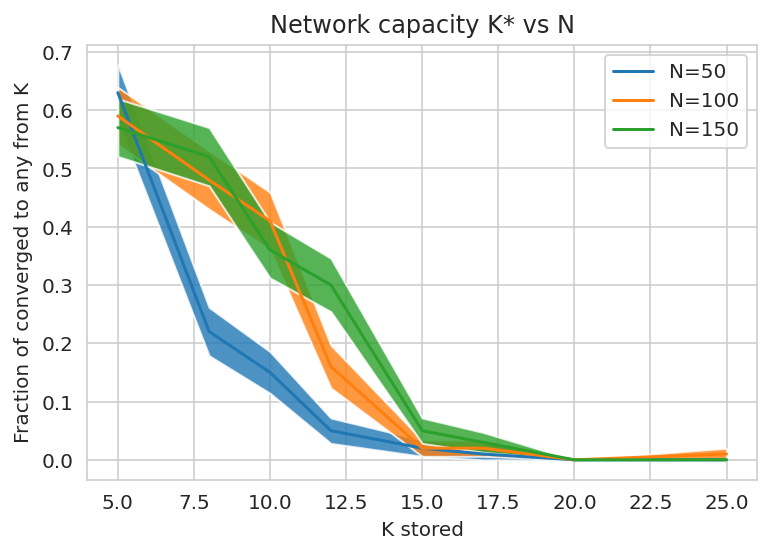

In [ ]:
plot_Network_capacity_vs_N(retrival_async, Ns)

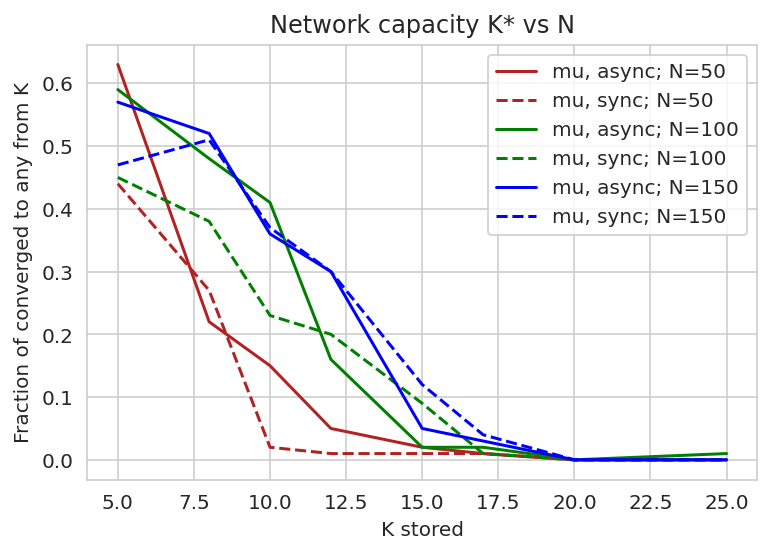

In [ ]:
plot_Network_capacity_vs_N_for_two_update_rules(retrival_async, retrival_sync, Ns)

Here we plot retrival rate (to *any* stable point) vs Hamming distance from a given stable point. 
We observe that small deviations (e.g. 5 errors for 100 dimensional vector) are successfully linked to stored patterns even for K>K*=0.14*N. However, as we probe vectors with more errors (occupying unseen parts of the energy landscape), de-corruption ability of the Hopfield Networks with K>0.14*N drops much quicker.

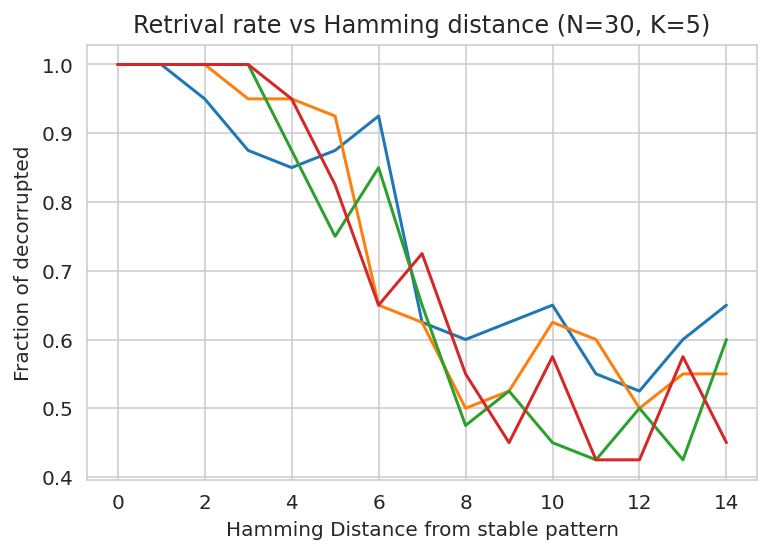

In [ ]:
### Plot Hamming Distance (state of corruption) vs probability to retrive memorized state
N, K = 30, 5
hammings = np.arange(15)
W, ks = generate_binary_Hopfield_Net(N, K)
res, meta = retrival_rate_vs_error(W, ks, update_rule_async_random, hammings,)
plot_Hamming_dist_vs_retival_rate(res, N, K, hammings)

In [ ]:
make_animated_heatmap(res)

In [ ]:
# This might take a while ~3 min
Ns, Ks = [100]*7, [5, 8, 10, 12, 15, 17, 20]
reses = []
for N,K in zip(Ns, Ks):
    W, ks = generate_binary_Hopfield_Net(N, K)
    hammings = np.arange(0, N//3, 3)
    res, meta = retrival_rate_vs_error(W, ks, update_rule_async_random, hammings, use_first_k=5)
    reses.append(res)

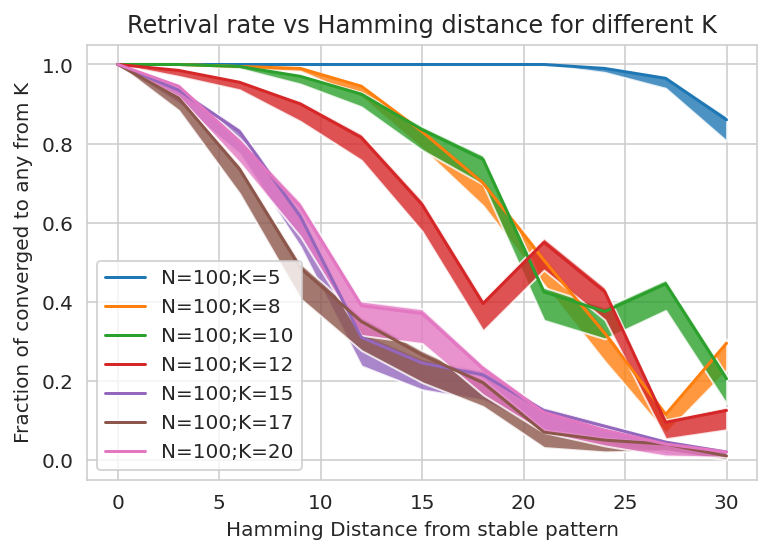

In [ ]:
plot_Hamming_dist_vs_retrival_rate_NEW(reses, Ns, Ks, hammings, save=True, suffix='combined')

### Theoretical limitations of the binary Hopfield Net's storage capacity result from the Hebbian Rule: 
(TODO)

In [ ]:
# If we build W from N vectors and every vector will be orthogonal - when *any* random vector will be stored (placed in local minima)
# however it is tricky to make orthogonalization of binary vectors (at least I couldn't invent quick solution)
ks = np.ones([30,30])
np.fill_diagonal(ks, -1)
W = ks@ks.T

In [ ]:
q=np.random.choice([-1,1], 30) 
np.sign(W@q)==q

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

### Corrupt MNIST

In [ ]:
from torchvision.datasets import MNIST
from PIL import Image
dt = MNIST(root='sample_data/', download=True)

Extracting sample_data/MNIST/raw/train-images-idx3-ubyte.gz to sample_data/MNIST/raw


Extracting sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data/MNIST/raw




Extracting sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/MNIST/raw


Extracting sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



Done!


In [ ]:
images, classes = [], []
for i in range(3):
    m,c = dt[i]
    #m.save(f'Pictures/mnist_{i}.png')
    m = np.array(m)
    m = 2*((m > 20).astype(int))-1
    images.append(m)
    classes.append(c)

### Functions defined

In [ ]:
def construct_Hopfield_Network_from_data(ks: np.ndarray, normalize=True, zero_diag=False):
    """
        Construct Hopfield Network from K vectors of size [1,N].
        input:
            - ks: binary vectors  
        outputs:
            - W: Hopfield Net matrix with Hebbian weigths [N,N]
    """
    W = ks.T@ks
    if normalize:
        W = W*(1/W.shape[0])
    if zero_diag:
        np.fill_diagonal(W,0)
    return W

In [ ]:
def corrupt_image(img, p=0.1):
    eps = np.random.choice([-10,0,10], size=[28,28], p=[p*0.5,1-p, p*0.5])
    img = np.clip(img + eps, -1, 1)
    return img

### operations

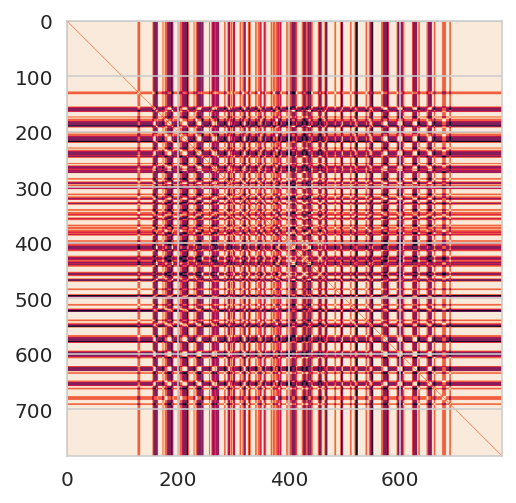

In [ ]:
data = np.stack([m.ravel() for m in images])
W = construct_Hopfield_Network_from_data(data, normalize=True, zero_diag=True)
plt.imshow(W)

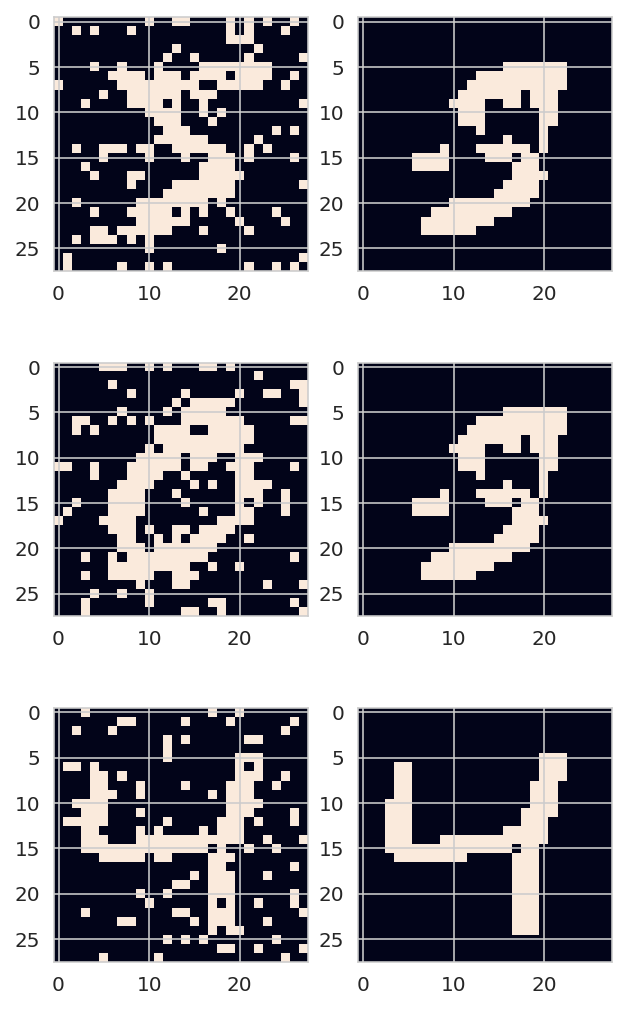

In [ ]:
### Even for just a two MNIST digits we get convoluted memories - probably because the signal/background ratio is too low
### so every picture vector [1,784] looks very similar due to dark background
assert len(images)<10, "Nope, human can not comprehend so many MNIST pictures at once!"
fig, ax = plt.subplots(len(images),2, figsize=(5, len(images)*3))
for i in range(len(images)):
  query = corrupt_image(images[i], p=0.25).ravel()
  query_retrived, E_traj, q_traj = retrive_memorized(query.copy(), W, update_rule_async_random)
  ax[i,0].imshow(query.reshape([28,28]))
  ax[i,1].imshow(query_retrived.reshape([28,28]))
#Image.fromarray(np.clip(255*(query+1), 0, 255).reshape([28,28]).astype(np.uint8)).save('Pictures/mnist_corrupted_5.png')

In [ ]:
# query = corrupt_image(images[0], p=0.25).ravel()
# query_retrived, E_traj, q_traj = retrive_memorized(query.copy(), W, update_rule_async_random)
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(query.reshape([28,28]))
# ax[1].imshow(query_retrived.reshape([28,28]))
# #Image.fromarray(np.clip(255*(query+1), 0, 255).reshape([28,28]).astype(np.uint8)).save('Pictures/mnist_corrupted_5.png')

### Modern Hopfield Networks with better Energy Functions (TODO)

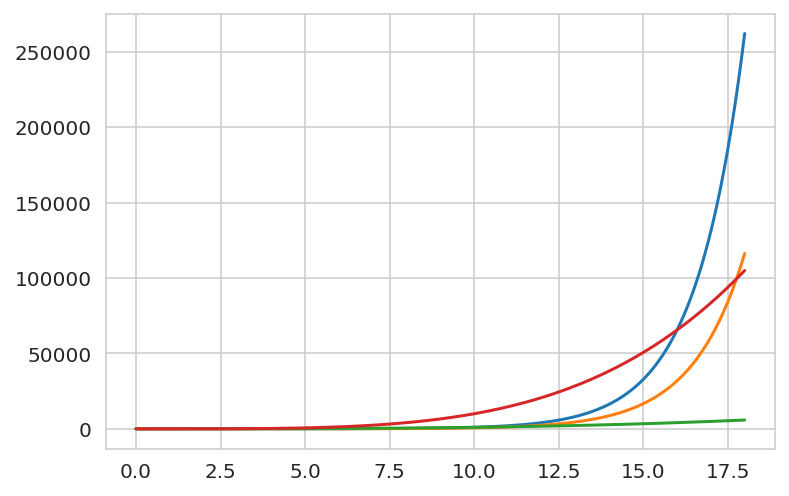

In [ ]:
# Comparing power law and exponential for different constants

from scipy.signal import find_peaks
find_peaks(1/(Es+1e-5))

t = np.linspace(0,18,200)
plt.plot(t, 2**t)
plt.plot(t, 2.71**(0.65*t))
plt.plot(t, t**3)
plt.plot(t, t**4)